<a href="https://colab.research.google.com/github/RoyArkh/MLbasics/blob/main/pytorch_01_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

#*1. Working with Data: Data prep*

Using linear regression for that (y = bx + a)

In [ ]:
weight = 0.7 #this is our b from the formula
bias = 0.3 #this is the a from the formula

#now we create the structure
start = 0
end = 1
step = 0.02

#creating the matrix with the known vars we chose
MATRIX = torch.arange(start, end, step).unsqueeze(dim=1) #the matrix names are capital by convention
y = weight * MATRIX + bias #from the formula of linear regression; by convention vector names are lowercase

MATRIX[:10], y[:10], len(MATRIX), len(y)

#the point is to make a model that will understand the mapping from METRIX to y

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

In [ ]:
#splitting the data set 80/20 % for training and testing respectively

train_split = int(0.8 * len(MATRIX)) #the testing samples (=40 which is 80% of the total 50 samples)

MATRIX_train = MATRIX[:train_split] #getting the training data
y_train = y[:train_split]

MATRIX_test, y_test = MATRIX[train_split:], y[train_split:] #getting the testing data

In [ ]:
len(MATRIX_train), len(y_train), len(MATRIX_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
def plot_predictions(train_data = MATRIX_train, train_labels = y_train, test_data = MATRIX_test, test_labels = y_test, predictions = None):
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions != None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    plt.legend(prop={"size": 14});

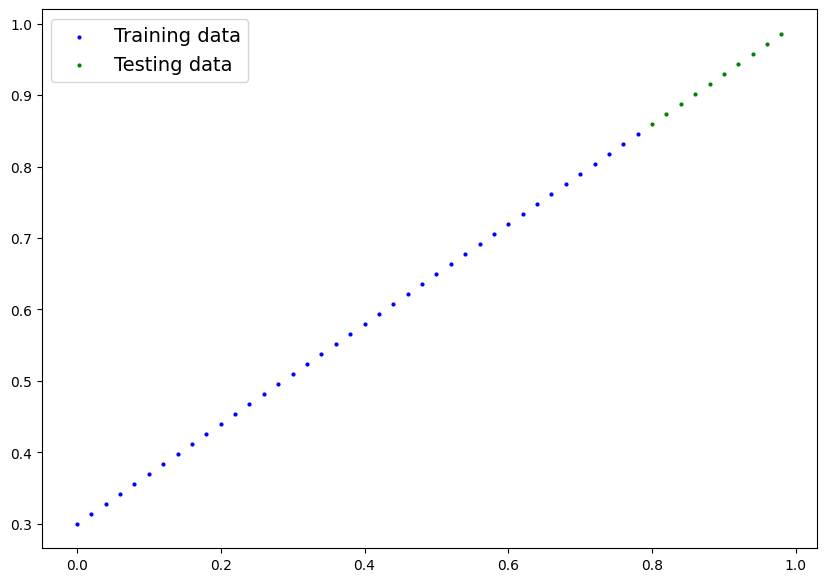

In [ ]:
plot_predictions()

#*2. Making model*
start w random values, adjust, repeat.
2 main algos: gradient descent; back propogation
important things for building models:
1. torch.nn - everything for computational graphs
2. torch.nn.Parameter - the things that model is supposed to learn, usually layers set by pytorch
3. torch.nn.Module - base class for all modules, override forward
4. torch.optim - optimizing w algorithms
5. forward() - defines the computation

In [ ]:
from torch import nn

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

In [ ]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
#listing named
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
weight, bias

(0.7, 0.3)

In [ ]:
#to see how good it predicts we will use x and y test

with torch.inference_mode(): #when inference mode? when no training, so that pytorch doesnt keep track of gradients and other potentially useless data -> makes larger datasets faster generated
    y_preds = model_0(MATRIX_test)

y_preds, y_test

(tensor([[0.3982],
         [0.4049],
         [0.4116],
         [0.4184],
         [0.4251],
         [0.4318],
         [0.4386],
         [0.4453],
         [0.4520],
         [0.4588]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

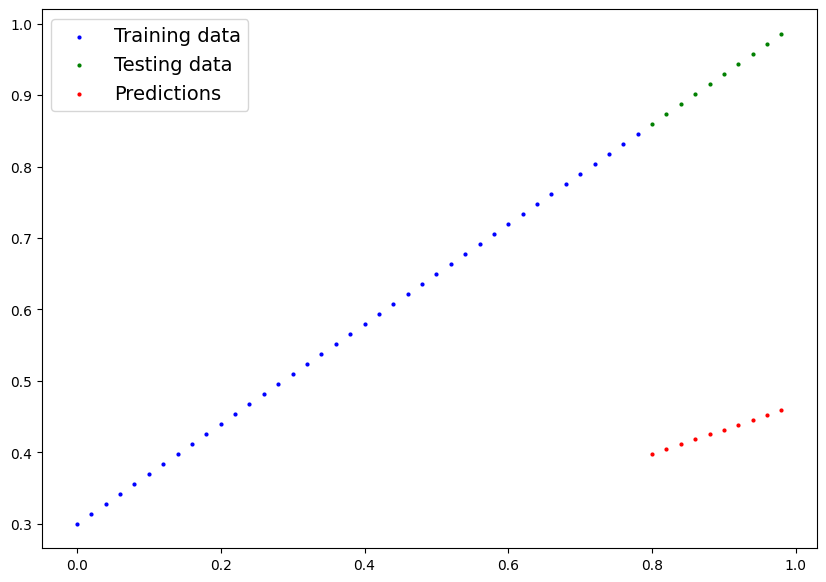

In [ ]:
plot_predictions(predictions=y_preds)

#*3.Training*

In [ ]:
#to measure how shit your model is we use loss functions (synonyms: cost func, criterion)
#to make things better we will have an optimizer which will see the loss func and adjust parameters

In [ ]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
#for pytorch we need training and testing loops

In [ ]:
#first set up loss functions
loss_func_0 = nn.L1Loss()

#second - optimizer; optimizer takes the parameters of the model and the learning rate (lr)
optimizer_0 = torch.optim.SGD(params=model_0.parameters(),
                              lr=0.01)
#lr is the amount of adjustment we do to our training set to get it as close as possible to the values we want

In [ ]:
#THE TRAINING LOOP
torch.manual_seed(42)

epochs = 100 #number of epochs that I will take my training through

#tracking values can be done to later improve on the results with a different model
epoch_count = []
loss_values = []
test_loss_values = []

for epoch in range(epochs+1):
    model_0.train() #pytorch sets the model into the training mode
    y_pred = model_0(MATRIX_train) #the forward pass
    loss = loss_func_0(y_pred, y_train) #calculating the loss
    optimizer_0.zero_grad() #zero out the optimizer grad; otherwise optimizer changes accumulate
    loss.backward() #backpropagation on loss w respect to params of model: calc gradient of each param
    optimizer_0.step() #gradient desc.: parameter updates, reevaluates the model, returns loss

    model_0.eval() #test the model; turns off stuff which is not used in testing
    with torch.inference_mode():
        test_pred = model_0(MATRIX_test) #forward pass
        test_loss = loss_func_0(test_pred, y_test) #calc loss

    if (epoch % 20 == 0): #just reporting
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(epoch, loss, test_loss)
        print(model_0.state_dict())

    #print(model_0.state_dict())

0 tensor(0.3129, grad_fn=<MeanBackward0>) tensor(0.4811)
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
20 tensor(0.0891, grad_fn=<MeanBackward0>) tensor(0.2173)
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
40 tensor(0.0454, grad_fn=<MeanBackward0>) tensor(0.1136)
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
60 tensor(0.0382, grad_fn=<MeanBackward0>) tensor(0.0889)
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788]))])
80 tensor(0.0313, grad_fn=<MeanBackward0>) tensor(0.0723)
OrderedDict([('weights', tensor([0.5459])), ('bias', tensor([0.3648]))])
100 tensor(0.0245, grad_fn=<MeanBackward0>) tensor(0.0565)
OrderedDict([('weights', tensor([0.5800])), ('bias', tensor([0.3503]))])


In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.5800])), ('bias', tensor([0.3503]))])

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.5800])), ('bias', tensor([0.3503]))])

In [ ]:
weight, bias

(0.7, 0.3)

In [ ]:
with torch.inference_mode():
    y_preds_new = model_0(MATRIX_test)

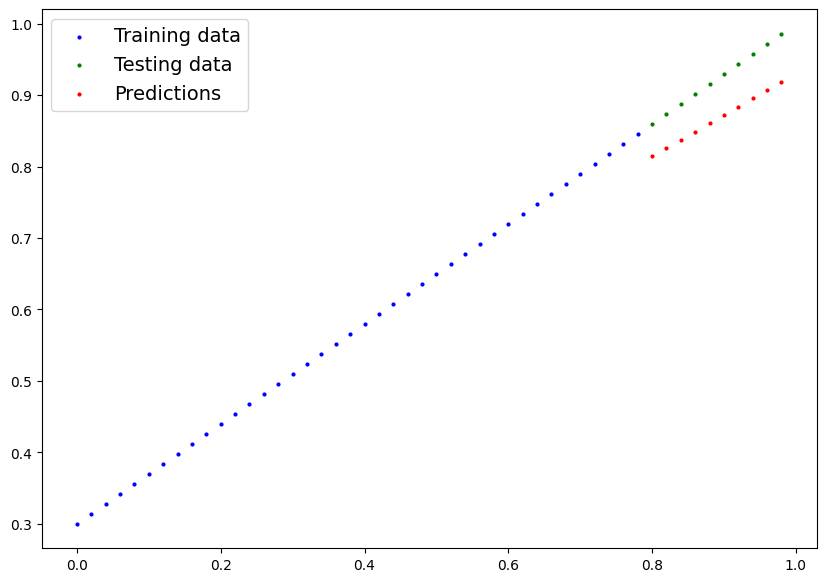

In [ ]:
plot_predictions(predictions=y_preds_new)

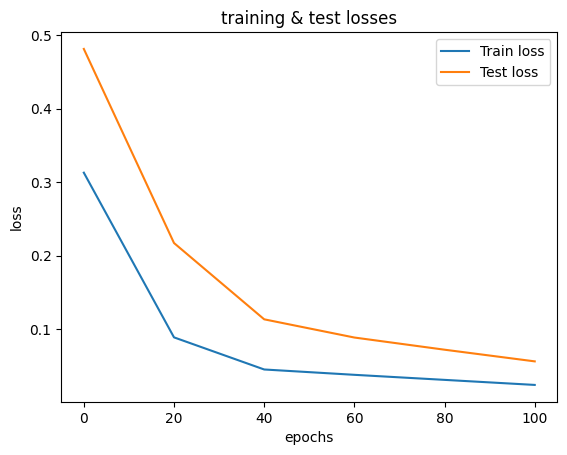

In [ ]:
import numpy as np

#plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).detach().numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("training & test losses")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend()

#*4.Saving & Loading*

In [ ]:
#torch.save() --> python pickle format
#torch.load() --> load saved obj
#torch.nn.Module.load_state_dict() --> load model's saved state dictionary

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.5800])), ('bias', tensor([0.3503]))])

In [ ]:
#to save first create dir
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#create path
MODEL_NAME = "01_pytorch_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

model_0.state_dict()

OrderedDict([('weights', tensor([0.5800])), ('bias', tensor([0.3503]))])

In [ ]:
#loading it back
torch.load(MODEL_SAVE_PATH)

OrderedDict([('weights', tensor([0.5800])), ('bias', tensor([0.3503]))])

In [ ]:
reloaded_model = LinearRegressionModel()
reloaded_model.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
reloaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
reloaded_model.state_dict()

OrderedDict([('weights', tensor([0.5800])), ('bias', tensor([0.3503]))])

In [ ]:
reloaded_model.eval()
with torch.inference_mode():
    reloaded_model_preds = model_0(MATRIX_test)

reloaded_model_preds

tensor([[0.8143],
        [0.8259],
        [0.8375],
        [0.8491],
        [0.8607],
        [0.8723],
        [0.8839],
        [0.8955],
        [0.9071],
        [0.9187]])

In [ ]:
model_0.eval()
with torch.inference_mode():
    zero_preds = model_0(MATRIX_test)


zero_preds == reloaded_model_preds #the models match up.

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

#*5. Practice*

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
weight = 5
bias = 0.5

start = 0
end = 10
step = 0.1

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
#X[:10], y[:10]
#len(X) , len(y)

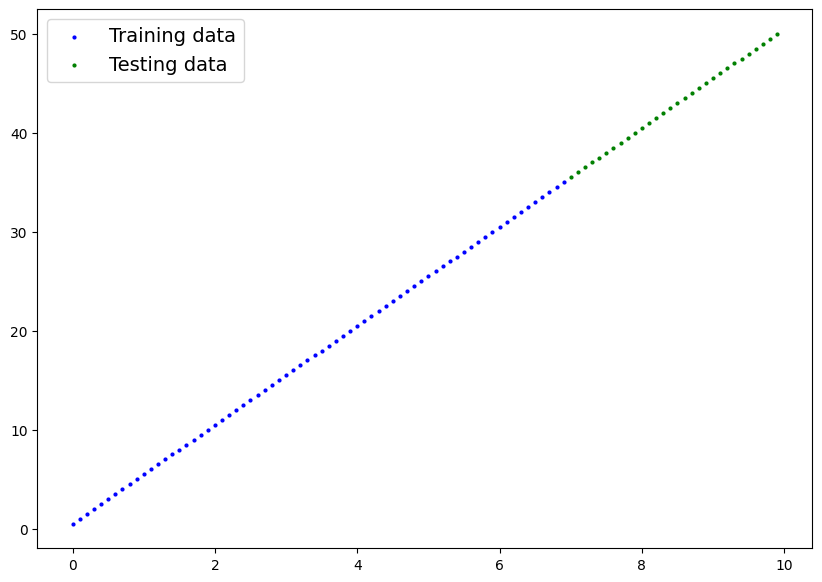

In [ ]:
train_amount = int(0.7 * len(X))
X_train, y_train = X[:train_amount], y[:train_amount]
X_test, y_test = X[train_amount:], y[train_amount:]
#len(X_train), len(y_train), len(X_test), len(y_test)

def plot_predictions(train_data = X_train, train_labels = y_train, test_data = X_test, test_labels = y_test, predictions = None):
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions != None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    plt.legend(prop={"size": 14});

plot_predictions();

In [ ]:
class LinearRegressionModel2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor,) -> torch.Tensor:
        return self.linear_layer(x)


torch.manual_seed(42)
model1 = LinearRegressionModel2()
model1, model1.state_dict()

(LinearRegressionModel2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [ ]:
model1.to(device)
next(model1.parameters()).device

loss_func1 = nn.L1Loss()
optimizer = torch.optim.SGD(params=model1.parameters(), lr = 0.01)

In [ ]:
torch.manual_seed(42)
epochs = 200

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs+1):
    model1.train()
    y_pred = model1(X_train)
    loss = loss_func1(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model1.eval()
    with torch.inference_mode():
        test_preds = model1(X_test)
        test_loss = loss_func1(test_preds, y_test)

    if epoch % 20 == 0:
        print("epoch: ", epoch, " loss: ", loss, " test loss: ", test_loss)

epoch:  0  loss:  tensor(13.9064, grad_fn=<MeanBackward0>)  test loss:  tensor(34.2547)
epoch:  20  loss:  tensor(11.3486, grad_fn=<MeanBackward0>)  test loss:  tensor(28.2383)
epoch:  40  loss:  tensor(8.8047, grad_fn=<MeanBackward0>)  test loss:  tensor(22.2333)
epoch:  60  loss:  tensor(6.2899, grad_fn=<MeanBackward0>)  test loss:  tensor(16.2556)
epoch:  80  loss:  tensor(3.8431, grad_fn=<MeanBackward0>)  test loss:  tensor(10.3494)
epoch:  100  loss:  tensor(1.6234, grad_fn=<MeanBackward0>)  test loss:  tensor(4.7245)
epoch:  120  loss:  tensor(0.5348, grad_fn=<MeanBackward0>)  test loss:  tensor(1.1145)
epoch:  140  loss:  tensor(0.4908, grad_fn=<MeanBackward0>)  test loss:  tensor(0.8789)
epoch:  160  loss:  tensor(0.4572, grad_fn=<MeanBackward0>)  test loss:  tensor(0.8068)
epoch:  180  loss:  tensor(0.4236, grad_fn=<MeanBackward0>)  test loss:  tensor(0.7347)
epoch:  200  loss:  tensor(0.3900, grad_fn=<MeanBackward0>)  test loss:  tensor(0.6748)


In [ ]:
model1.state_dict(), weight, bias

(OrderedDict([('linear_layer.weight', tensor([[4.8103]])),
              ('linear_layer.bias', tensor([1.4280]))]),
 5,
 0.5)

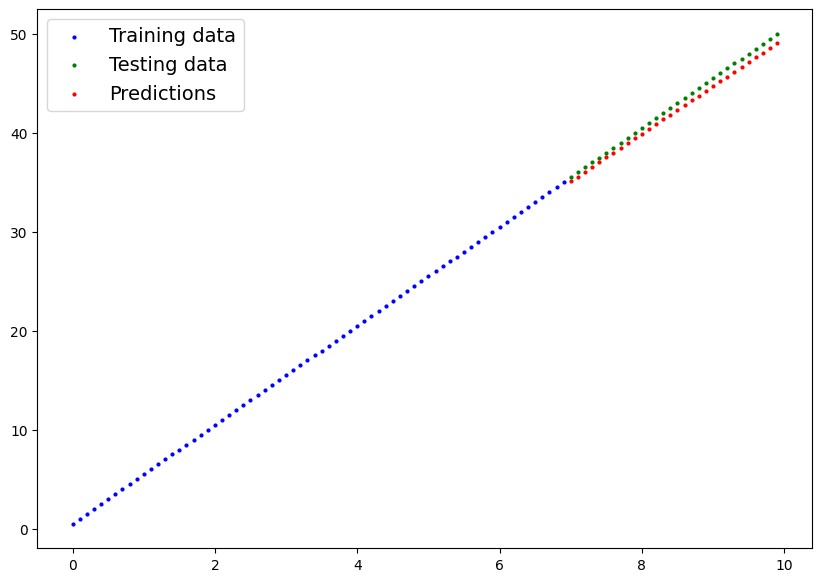

In [ ]:
with torch.inference_mode():
    y_preds = model1(X_test)

plot_predictions(predictions=y_preds)

In [ ]:
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "01_pytorch_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model1.state_dict(), f=MODEL_SAVE_PATH)